In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential, layers
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

### Bayesian switchpoint analysis

https://www.tensorflow.org/probability/examples/Bayesian_Switchpoint_Analysis

Text(0.5, 1.0, 'Mining disaster data set')

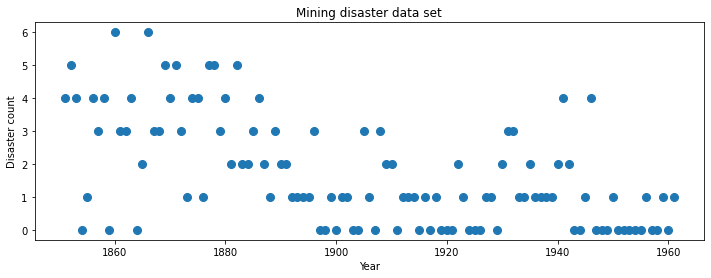

In [2]:
disaster_data = np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))
ax.plot(years, disaster_data, 'o', markersize=8);
ax.set_ylabel('Disaster count')
ax.set_xlabel('Year')
ax.set_title('Mining disaster data set')

#### MCMC approach

In [3]:
# These values will be re-used, so calculate them once
tf_min_year = tf.cast(tf.reduce_min(years), dtype=tf.float32)
tf_max_year = tf.cast(tf.reduce_max(years), dtype=tf.float32)

def disaster_count_model():
    """Return a probabalistic model for distaster count data.
    Early and late exponentially-distributed variables parameterize
    the Poisson before and after the switchpoint. The Switchpoint is
    uniformly distributed.
    """
    disaster_count = tfd.JointDistributionNamed(
        dict(
            early_rate=tfd.Exponential(rate=1.),
            late_rate=tfd.Exponential(rate=1.),
            switchpoint=tfd.Uniform(low=tf_min_year, high=tf_max_year),
            d_t=lambda switchpoint, late_rate, early_rate: tfd.Independent(
                tfd.Poisson(
                    rate=tf.where(years < switchpoint, early_rate, late_rate),
                    force_probs_to_zero_outside_support=True
                ),
                reinterpreted_batch_ndims=1
            )
        )
    )
    return disaster_count

model_switch = disaster_count_model()

2022-12-06 21:16:35.237644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 21:16:35.243017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 21:16:35.243197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 21:16:35.244311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
def target_log_prob_fn(model, switchpoint, early_rate, late_rate):
  """Return log probability of the data relative to the input parameters."""
  return model.log_prob(
    switchpoint=switchpoint,
    early_rate=early_rate,
    late_rate=late_rate,
    d_t=disaster_data
  )

print(target_log_prob_fn(model_switch, 1880., 3., .9).numpy())  # Somewhat likely result
print(target_log_prob_fn(model_switch, 1855., 1., 5.).numpy())  # Very unlikely result
print(target_log_prob_fn(model_switch, -10., 1., 1.).numpy())   # Impossible result

Instructions for updating:
The `interpolate_nondiscrete` flag is deprecated; instead use `force_probs_to_zero_outside_support` (with the opposite sense).
-189.95576
-378.0294
-inf


>Therefore we constrain the space that HMC shall examine by wrapping the HMC kernel with a TransformedTransitionKernel that specifies the forward bijectors to transform the real numbers onto the domain that the probability distribution is defined on

In [5]:
num_burnin_steps = 3000
num_results = 10000
years_midpoint = (tf_max_year + tf_min_year) / 2.

@tf.function(autograph=False, jit_compile=True)
def make_chain(target_log_prob_fn):
    kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=target_log_prob_fn,
            step_size=0.05,
            num_leapfrog_steps=3
        ),
        bijector=[
            # The bijectors are arranged in the same order as the inputs
            # to the log_prob_fn.
            # The switchpoint is constrained between the start and end years.
            # Hence we supply a bijector that maps the real numbers (in a
            # differentiable way) to the interval (min_year;max_year)
            tfb.Sigmoid(low=tf_min_year, high=tf_max_year),
            # Early and late disaster rates are mapped to the positive real numbers
            tfb.Softplus(),
            tfb.Softplus()
        ]
    )
    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=int(0.8*num_burnin_steps)
    )
    states = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=[
            # Starting values for the three latent variables
            tf.ones([], name='init_switchpoint')*(tf_max_year+tf_min_year)/2,
            tf.ones([], name='init_early_rate'),
            tf.ones([], name='init_late_rate'),
        ],
        trace_fn=None,
        kernel=kernel
    )
    return states

# Provide model to log_prob_fn and pass through sampled variables
switch_samples = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_switch, *args))
]
switch_samples

2022-12-06 21:16:37.529435: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x1f7ec4f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-06 21:16:37.529483: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2022-12-06 21:16:37.583131: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-06 21:16:37.610485: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
2022-12-06 21:16:40.126346: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-06 21:16:40.374900: I tensorflow/compiler/jit/xla_compilation_cache.c

[array([1892.608 , 1892.0696, 1890.1559, ..., 1892.7325, 1894.578 ,
        1893.8462], dtype=float32),
 array([2.8018734, 2.6729813, 2.690909 , ..., 2.6667562, 2.7040253,
        2.7618582], dtype=float32),
 array([0.98749197, 0.9565108 , 0.89368904, ..., 1.1119663 , 1.0868398 ,
        1.0522591 ], dtype=float32)]

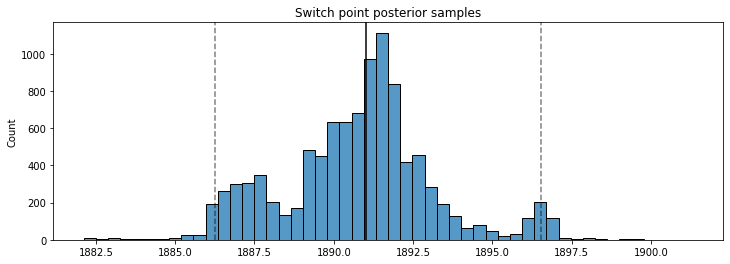

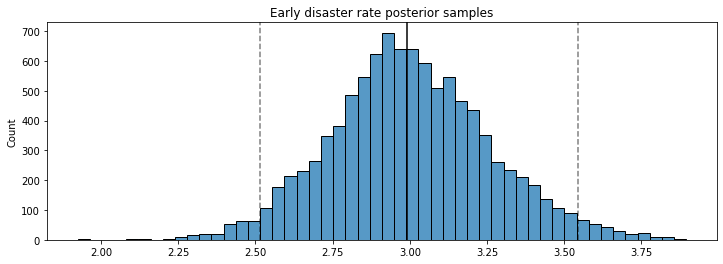

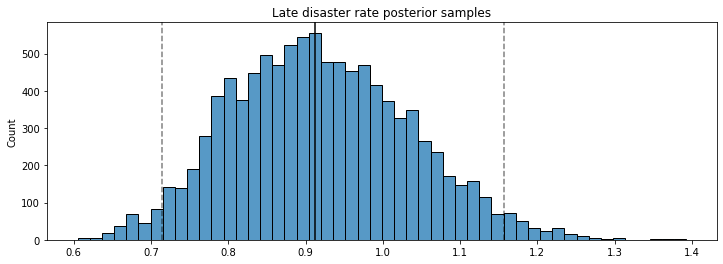

In [6]:
def plot_latent_variable_samples(switch_point_samples, early_rate_samples, late_rate_samples):
    for title, values in [
        ('Switch point posterior samples', switch_point_samples),
        ('Early disaster rate posterior samples', early_rate_samples),
        ('Late disaster rate posterior samples', late_rate_samples),
    ]:
        fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,4))
        sns.histplot(x=values, bins=50, ax=ax)
        ax.axvline(x=np.percentile(values, 50), color='k')
        ax.axvline(x=np.percentile(values, 2.5), color='k', ls='dashed', alpha=.5)
        ax.axvline(x=np.percentile(values, 97.5), color='k', ls='dashed', alpha=.5)
        ax.set_title(title)
        plt.show()

plot_latent_variable_samples(switch_samples[0], switch_samples[1], switch_samples[2])

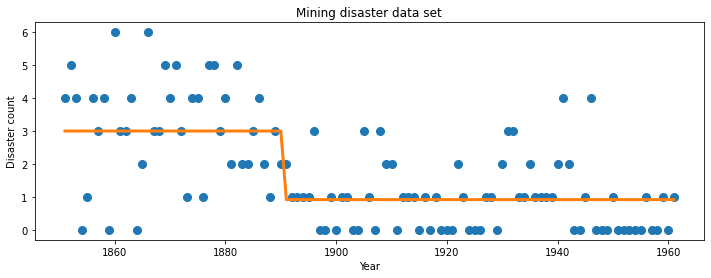

In [7]:
def plot_rate_switch(switch_point_samples, early_rate_samples, late_rate_samples):
    rates = np.ones(years.shape) * np.mean(early_rate_samples)
    rates[years >= np.mean(switch_point_samples)] = np.mean(late_rate_samples)
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))
    ax.plot(years, disaster_data, 'o', markersize=8);
    ax.plot(years, rates, linewidth=3)
    ax.set_ylabel('Disaster count')
    ax.set_xlabel('Year')
    ax.set_title('Mining disaster data set')
    plt.show()

plot_rate_switch(switch_samples[0], switch_samples[1], switch_samples[2])

#### Variational Inference approach

In [8]:
# Define the probabilistic graphical model as a JointDistribution.
@tfd.JointDistributionCoroutineAutoBatched
def vi_model():
    early_rate = yield tfd.Exponential(rate=1., name='early_rate')
    late_rate = yield tfd.Exponential(rate=1., name='late_rate')
    switchpoint = yield tfd.Uniform(low=tf_min_year, high=tf_max_year, name='switchpoint')
    yield tfd.Poisson(
        rate=tf.where(years < switchpoint, early_rate, late_rate),
        force_probs_to_zero_outside_support=True,
        name='d_t'
    )

# Pin the observed values to model the un-normalized posterior.
# This is equivalent to the target_log_prob_fn() earlier, in that it
# forces the log probability to be relative to the input data
target_model = vi_model.experimental_pin(d_t=disaster_data)

In [9]:
# Determine the `event_shape` of the posterior, and calculate the size of each
# `event_shape` component. These determine the sizes of the components of the
# underlying Normal distribution.
event_shape = target_model.event_shape_tensor()
flat_event_shape = tf.nest.flatten(event_shape)
flat_event_size = tf.nest.map_structure(tf.reduce_prod, flat_event_shape)

# The `event_space_bijector` maps unconstrained values (in R^n) to the support
# of the prior -- we'll need this to constrain Normal samples to the prior's
# support.
event_space_bijector = target_model.experimental_default_event_space_bijector()

# Restructure the flat list of components to match the prior's structure
unflatten_bijector = tfb.Restructure(
    tf.nest.pack_sequence_as(event_shape, range(len(flat_event_shape)))
)

# Reshape each component to match the prior, using a nested structure of
# `Reshape` bijectors wrapped in `JointMap` to form a multipart bijector.
reshape_bijector = tfb.JointMap(
    tf.nest.map_structure(tfb.Reshape, flat_event_shape)
)

In [10]:
# Take a peek at the event shape and flat shape
# These are what the bijectors transform between
event_shape, flat_event_shape, flat_event_size

(StructTuple(
   early_rate=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
   late_rate=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
   switchpoint=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>
 ),
 [<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  <tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  <tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>],
 [<tf.Tensor: shape=(), dtype=int32, numpy=1>,
  <tf.Tensor: shape=(), dtype=int32, numpy=1>,
  <tf.Tensor: shape=(), dtype=int32, numpy=1>])

In [11]:
# Build a standard Normal with a vector `event_shape`, with length equal to the
# total number of degrees of freedom in the posterior.
base_distribution = tfd.Sample(
    tfd.Normal(0., 1.), sample_shape=[tf.reduce_sum(flat_event_size)]
)

# Apply an Inverted Autoregressive Flow to the base distribution.
# This is a neural network that learns to shift, scale and non-linearly-transform
# a probability distribution.
num_iafs = 2
hidden_size = 32
num_hidden_layers = 2
iaf_bijectors = [
    tfb.Invert(
        tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
                params=2,
                hidden_units=[hidden_size]*num_hidden_layers,
                activation='relu'
            )
        )
    )
    for _ in range(num_iafs)
]

# Split the base distribution's `event_shape` into components that are equal
# in size to the prior's components.
split = tfb.Split(flat_event_size)

# Chain these bijectors and apply them to the standard Normal base distribution
# to build the surrogate posterior. `event_space_bijector`,
# `unflatten_bijector`, and `reshape_bijector` are the same as in the
# multivariate Normal surrogate posterior.
iaf_surrogate_posterior = tfd.TransformedDistribution(
    base_distribution,
    bijector=tfb.Chain([
        event_space_bijector,  # constrain the surrogate to the support of the prior
        unflatten_bijector,  # pack the reshaped components into the `event_shape` structure of the prior
        reshape_bijector,  # reshape the vector-valued components to match the shapes of the prior components
        split] +  # Split the samples into components of the same size as the prior components
        iaf_bijectors  # Apply a flow model to the Tensor-valued standard Normal distribution
    )
)

2022-12-06 21:16:58.700090: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


IAF surrogate posterior ELBO: -198.2089385986328


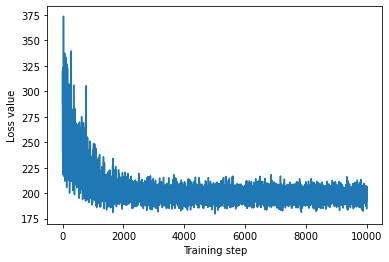

In [12]:
optimizer = tf.optimizers.Adam(learning_rate=0.001)
iaf_loss = tfp.vi.fit_surrogate_posterior(
    target_model.unnormalized_log_prob,
    iaf_surrogate_posterior,
    optimizer=optimizer,
    num_steps=10**4,
    sample_size=4,
    jit_compile=True
)

iaf_samples = iaf_surrogate_posterior.sample(1000)
iaf_final_elbo = tf.reduce_mean(
    target_model.unnormalized_log_prob(*iaf_samples)
    - iaf_surrogate_posterior.log_prob(iaf_samples)
)
print('IAF surrogate posterior ELBO: {}'.format(iaf_final_elbo))

plt.plot(iaf_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')

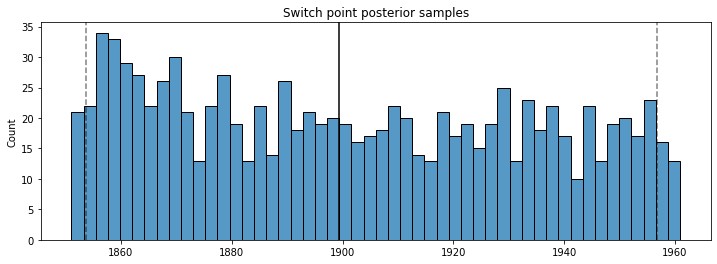

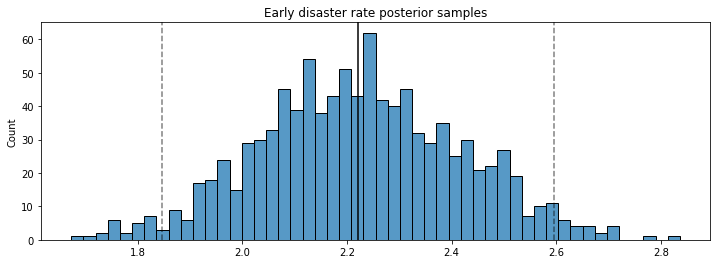

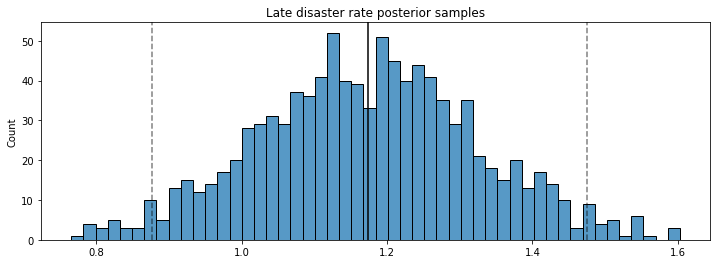

In [13]:
plot_latent_variable_samples(
    iaf_samples.switchpoint.numpy(),
    iaf_samples.early_rate.numpy(),
    iaf_samples.late_rate.numpy()
)

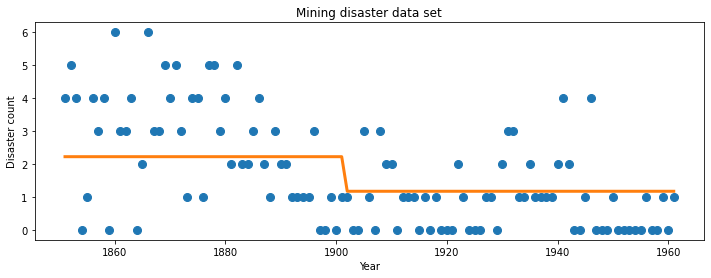

In [14]:
plot_rate_switch(
    iaf_samples.switchpoint.numpy(),
    iaf_samples.early_rate.numpy(),
    iaf_samples.late_rate.numpy()
)